**Experimental Description**: Experimental data was collected for steady state was measured for four strains, each containing four different beta-estradiol inducible cascades. Each of the four strains was induced with eighteen different doses of βe ranging from 0 to 100 μM in a single batch of seventy-two cultures. Cells were diluted every eight hours to prevent culture saturation. Steady-state fluorescence readings were taken after five days when the cultures were in log-phase. 

**Model Description**: A series of hill-functions B (table X) was used to fit kinetics and dose-response data independently using the same model. For the steady-state model, a βe-to-expression transfer function was created from a βe inducible yeast-enhanced YFP (data not shown). Relative expression of sgRNA was normalized to an equivalent dose of 100 μM βe and multiplied by the parameter u.

**Fitting Procedure**: Parameters were optimized using differential evolution (DE) followed by minimization using the Broyden-Fletcher-Goldfarb-Shanno (BFGS) algorithm. One hundred optimal fits were generated using DE/BFGS. Parameter distributions exhibited a non-normal distribution with a single clear central tendency. Parameter mean and uncertainty in the fitting parameters were determined by taking the means and variances of the one hundred parameter sets. 

**Monte-Carlo Simulations**: Averages and standard deviations of a1-4 and k1-4 were used to determine global parameters for a and k. Parameter uncertainty For model projections and Monte-Carlo simulations parameter distributions were assumed to be normally distributed around the mean. 10,000 simulations were generated from parameter distributions using the model.

* Reference for Diff. Evo.: Storn, R and Price, K, Differential Evolution - a Simple and Efficient Heuristic for Global Optimization over Continuous Spaces, Journal of Global Optimization, 1997, 11, 341 - 359. *

<h2> Model Equations </h2>
$$ m\in{0,1,...M} $$
$$ r_M(β) = u \frac{A K β^n}{B (1+K β^n)} $$
$$ \dot{r_{m}}(u) = \frac{a_m}{1+k_m r_{m+1}} - b r_m $$
$$ r_0(u) \propto GFP(u) $$


|                    |         $\frac{dGFP}{dt}$         | $\frac{dr_1}{dt}$                 | $\frac{dr_2}{dt}$                 | $\frac{dr_3}{dt}$                 | $\frac{dr_4}{dt}$ |
|--------------------|:---------------------------------:|-----------------------------------|-----------------------------------|-----------------------------------|-------------------|
| **Layer 1 (6059)** | $\frac{a_0}{1+k_0 r_1^n} - β r_0$ | $u - β r_1$                     |                                   |                                   |                   |
| **Layer 2 (6325)** | $\frac{a_0}{1+k_0 r_1^n} - β r_0$ | $\frac{a_1}{1+k_1 r_2^n} - β r_1$ | $u - β r_2$                     |                                   |                   |
| **Layer 3 (6326)** | $\frac{a_0}{1+k_0 r_1^n} - β r_0$ | $\frac{a_1}{1+k_1 r_2^n} - β r_1$ | $\frac{a_2}{1+k_2 r_3^n} - β r_2$ | $u - β r_3$                     |                   |
| **Layer 4 (6327)** | $\frac{a_0}{1+k_0 r_1^n} - β r_0$ | $\frac{a_1}{1+k_1 r_2^n} - β r_1$ | $\frac{a_2}{1+k_2 r_3^n} - β r_2$ | $\frac{a_3}{1+k_3 r_4^n} - β r_3$ | $u - β r_4$     |


| Parameter | Meaning                                              |
|-----------|------------------------------------------------------|
| a         | promoter strength                                    |
| k         | repression binding strength and respression strength |
| b         | degradation/dilution of gRNA:dCas9-mxi1              |
| u         | maximum induction of pGALZ4:Zev4 promoter            |
| n         | hill-coefficient                                     |

Parameter Units:

a: promoter strength Au/t    (Scaling Factor: multiply by 1600/25)

k: repression strength 1/Au^n    (Scaling Factor: divide by 1600^n)

b: dilution factor 1/t     (Scaling Factor: divide by 25)

u: input strength (the strength of the inducible promoter   Au/t     (Scaling Factor: multiply by 1600/25


In [1]:
################################### Define Filenames ###################################
import os
#user = "soslab"
user = "Justin"
root = os.path.join("/Users/", user, "Documents/Programming/CRISPRCascadeAnalysis/")
datafolder = os.path.join(root, "Data")
montecarlofolder = os.path.join(datafolder, "MonteCarlo")
hyakfolder = os.path.join(datafolder, "hyakfitting_results")

combined_filename = os.path.join(hyakfolder, "bestfits_combined_indexed.csv")
kinetics_filename = os.path.join(hyakfolder, "bestfits_kinetics_indexed.csv")
steadystate_filename = os.path.join(hyakfolder, "bestfits_steadystate_indexed.csv")
kinetics_new_filename = os.path.join(hyakfolder, "bestfits_kinetics_new_indexed.csv")
finalfolder = os.path.join(root, "FinalData")

***

<h1> Determine Parameter Uncertainties from Fits </h1>

***

In [2]:
import os
import pandas as pd
from IPython import display
import scipy
import pylab as plt
import numpy as np
%matplotlib inline

def getParamUncertainties(filename, chooseb=0):
    pds = pd.read_csv(filename, header=[0,1], index_col=0)
    pds.drop(pds.columns[12:15], axis=1, inplace=True)
    
    pds['weight'] = pds['score'].apply(lambda x: (1.0/x)**1)
    #CIs = bootstrap.ci(data=pds, statfunction=scipy.mean)
    #print CIs
    average = pds.apply(np.mean)
    std = pds.apply(np.std)
    a_mean = np.average(average['a'], weights=std['a'])
    a_var = np.average((average['a'] - a_mean)**2, weights=std['a'])
    a_std = np.sqrt(a_var)
    
    k_mean = np.average(average['k'], weights=std['k'])
    k_var = np.average((average['k'] - k_mean)**2, weights=std['k'])
    k_std = np.sqrt(k_var)
    
    b_mean = average['b'][chooseb]
    b_std = std['b'][chooseb]
    u_mean = average['u'][0]
    u_std = std['u'][0]
    n_mean = average['n']
    n_std = std['n']
    
    labels = list('akbun')
    means = a_mean, k_mean, b_mean, u_mean, n_mean
    sd = [a_std, k_std, b_std, u_std, n_std]
    means = [float(x) for x in means]
    sd = [float(x) for x in sd]
    globalparams = pd.DataFrame([means, sd], columns=labels, index=["mean", "std"]).transpose()
    modelparams = pd.DataFrame([average, std], index=["mean", "std"]).transpose()
    modelparams.drop('weight', level=0, axis=0, inplace=True)
    modelparams.drop('score', level=0, axis=0, inplace=True)
    return modelparams, globalparams

m, g = getParamUncertainties(combined_filename)
m

IOError: File /Users/Justin/Documents/Programming/CRISPRCascadeAnalysis/Data/hyakfitting_results/bestfits_combined_indexed.csv does not exist

***

<h1> Modeling Definitions </h1>

***

In [ ]:
import numpy as np
import pandas as pd
from scipy import integrate
from scipy import optimize
import pylab as plt
import pandas as pd
%matplotlib inline


def cascade_kinetics(t, r, a, k, b, u, n):
    layer_depth = len(r) - 1
    dR = [0] * len(r)
    dR[layer_depth] = u - b * r[layer_depth]
    for l in range(layer_depth)[::-1]:
        dR[l] = a[l] / (1+k[l] * r[l+1] ** n) - b * r[l]
    return dR

def cascade_ss(layer_depth, a, k, b, u, n):
    assert len(a) == len(k)
    assert len(a) >= layer_depth
    R = [0]*(layer_depth+1)
    R[layer_depth] = u/b
    for l in range(layer_depth)[::-1]:
        R[l] = a[l] / ((1+k[l] * R[l+1] ** n)*b)
    return np.array(R)

def tfxn(inducer_at_max, inducer):
    AB = 542.8745566
    K = 0.269635359
    n = 1.238933919
    def fxn(u):
        return (AB*K*u**n)/(1+K*u**n)
    rel_induction = fxn(inducer)/fxn(inducer_at_max)
    return rel_induction

t_final = 500.
dt = 1.0


def integrateSystem(numlayers, a, k, b, u, n):
    ss = cascade_ss(numlayers, a, k, b, 0.0, n)
    r1 = integrate.ode(cascade_kinetics)
    r1.set_initial_value(ss).set_f_params(a, k, b, u, n)
    data1 = []
    while r1.successful() and r1.t < t_final:
        r1.integrate(r1.t+dt)
        data1.append( [r1.t] + [float(i) for i in list(r1.y)] )
    return data1


def ssModel(i_array, a, k, b, u, n):
    assert len(a) == len(k)
    num_layers = len(a)+1
    dose = pd.DataFrame(index = i_array, columns = list(range(1,num_layers+1)) + ['rel exp'])
    for i in i_array:
        rel_exp = tfxn(100.0, i)
        rel_u = rel_exp * u
        dose.loc[i] = [cascade_ss(l, a, k, b, rel_u, n)[0] for l in range(num_layers)] + [rel_exp]
    return dose


def kineticsModel(a, k, b, u, n):
    assert len(a) == len(k)
    num_layers = len(a)+1
    layers = {}
    time = []
    for l in range(num_layers):
        system = integrateSystem(l, a, k, b, u, n)
        unzipped = zip(*system)
        layers[l] = unzipped[1]
        time = unzipped[0]
    return pd.DataFrame(layers, index=time)


def getTimeToHalfMaximum(trajectory, init, ss, ds):
    half = ss - init
    half = half/2.0
    half = ss - half
    ttss = []
    g = np.abs(trajectory - half)
    ttss = g.apply(np.argmin)
    return ttss

def getValue(t, df):
    i = np.abs(df.index - t).argmin()
    return df.iloc[i]

def cascadesystem_steadystate_simple(numlayers, a, k, b, u, n):
    
    Y = []
    Y.append(u/b)
    for i in range(numlayers):
        Y.append((1.*a/(1+k*Y[i]**n))/b)
    return np.array(Y)

def dynamic_range_plot(numlayers, a, k, b, u, n):
    params = [a,k,b,u,n]
    ss = cascadesystem_steadystate_simple(numlayers, *params)
    params = [a, k, b, 0.0, n]
    ss_0 = cascadesystem_steadystate_simple(numlayers, *params)
    #plt.yscale('log')
    #plt.plot(np.log10(np.abs(ss-ss_0)))
    dr = []
    for ss_value, ss_0_value in zip(ss, ss_0):
        values = [ss_value, ss_0_value]
        dr.append(max(values)/min(values))
    #return np.abs(ss-ss_0)
    metric = 20.0*np.log10(dr)
    #metric = np.abs(ss-ss_0)
    plt.plot(metric)
    return metric


***

<h1> Monte Carlo Simulations </h1>

***

In [127]:
t_final = 750.0
import os

def evaluateOnlySS(a, k, b, u, n):
    assert len(a) == len(k)
    ss = []
    ss_0 = []
    dr_array = []
    ss = cascade_ss(len(a), a, k, b, u, n)
    ss_0 = cascade_ss(len(a), a, k, b, 0.0, n)
    for ss_value, ss_0_value in zip(ss, ss_0):
        values = [ss_value, ss_0_value]
        dr = np.log10(max(values)/min(values))
        dr_array.append(dr)
    p = pd.DataFrame( {"ss": ss,
                      "ss_0": ss_0,
                      "dr": dr_array})
    p = p.unstack()
    p = pd.DataFrame(p).transpose()
    return p

def evaluateSystem(a, k, b, u, n, kmodel=False, dosemodel=False):
    global t_final, dt
    assert len(a) == len(k)
    dr_array = []
    ttss_array = []
    ss = []
    ss_0 = []
    dose_max_rate = []
    dose_inflection = []
    max_rate = []
    traj = None
    if kmodel:
        traj = kineticsModel(a, k, b, u, n)
        traj.columns = [1, 2, 3, 4, 5]
        ss_0 = traj.iloc[0]
        ss = traj.iloc[-1]
    else:
        ss = cascade_ss(len(a), a, k, b, u, n)
        ss_0 = cascade_ss(len(a), a, k, b, 0.0, n)
        traj = integrateSystem(len(a), a, k, b, u, n)
        traj = pd.DataFrame(traj)
        traj = traj.set_index(0) #only for integrate system, comment if using kinetics model
        traj.reindex()
        traj = pd.DataFrame(traj)
        i_array = 0.006*2**np.linspace(0,20,100)
    for ss_value, ss_0_value in zip(ss, ss_0):
        values = [ss_value, ss_0_value]
        dr = np.log10(max(values)/min(values))
        dr_array.append(dr)
    ttss_array = getTimeToHalfMaximum(traj, ss_0, ss, 0.001)
    max_rate = traj.apply(np.gradient).apply(np.abs).apply(np.max)/dt
    p = pd.DataFrame( {"ss": ss,
            "ss_0": ss_0,
            "dr": dr_array,
            "ttss": ttss_array,
            "max_rate": list(max_rate)} )
    if dosemodel:
        dose = ssModel(i_array, a, k, b, u, n)
        dose.drop('rel exp', axis=1, inplace=True)
        dose_deriv = dose.apply(np.gradient).apply(lambda x: x/np.gradient(dose.index))
        dose_max_rate = dose_deriv.apply(np.abs).apply(np.max)
        dose_inflection = dose_deriv.apply(np.abs).apply(np.argmax)
        p["dose_max_rate"] = list(dose_max_rate)
        p["dose_inflection"] = list(dose_inflection)
    p = p.unstack()
    p = pd.DataFrame(p).transpose()
    return p

message = ""
describe = ""

def modelbootstrap(input_filename, rounds=10, outfile=None, overwrite=False):
    paramset = pd.read_csv(input_filename, header=[0,1], index_col=0)
    ran_params = []
    global message, describe, t_final, dt
    t_final = 100.0
    dt = 0.1
    final_results = pd.DataFrame()
    for j in range(rounds):
        results = pd.DataFrame()
        display.clear_output(wait=True)
        display.display("Bootstrapped on %s" % input_filename)
        display.display("Round %d out of %d" % (j+1, rounds))
        display.display(describe)
        for i in range(len(paramset)):
            p = paramset.iloc[np.random.randint(0,len(paramset))]
            a = np.array(p['a'])
            k = np.array(p['k'])
            b = [float(p['b'])]
            u = [float(p['u'][0])]
            n = [float(p['n'])]
            params = np.concatenate([a, k, b, u, n])
            index = []
            for i, key in zip([4, 4, 1, 1, 1], list("akbun")):
                index = index + zip([key]*i, range(i))
            index = pd.MultiIndex.from_tuples(index)
            params = pd.DataFrame(params, index=index).transpose() #, columns = pd.MultiIndex.from_tuples(index))
            b = b[0]
            u = u[0]
            n = n[0]
            metrics = evaluateSystem(a, k, b, u, n, kmodel=True)
            joined = params.join(metrics)
            results = pd.concat([results, joined], ignore_index=True)
        results = pd.DataFrame(results.apply(np.mean)).transpose()
        final_results = pd.concat([final_results, results])
        final_results = final_results.reindex()
        message = final_results
    if not outfile == None:
        if not os.path.isfile(outfile) or overwrite:
            display.display("Writing to file %s" % os.path.basename(outfile))
            final_results.to_csv(outfile)
        else:
            savedresults = pd.read_csv(outfile, header=[0,1], index_col=0)
            savedresults.columns = final_results.columns
            message = "%d params read from file" % len(savedresults)
            message = message + '\n' + "Appending to file %s" % os.path.basename(outfile)
            newresults = pd.concat([savedresults, final_results], ignore_index=True)
            newresults.to_csv(outfile)
            describe = newresults.describe()
    display.display(message)
    return final_results

def bootstrap(numlayers, input_filename, n_boot=500, outfile=None, overwrite=False, n_bounds=None, n_force=None, dosemodel=True):
    global t_final, dt
    dt = 0.8
    t_final = 750.0
    paramset = pd.read_csv(input_filename, header=[0,1], index_col=0)
    ran_params = []
    results = pd.DataFrame()
    global message
    for i in range(n_boot):
        display.clear_output(wait=True)
        display.display("Bootstrapped on %s" % input_filename)
        display.display("Progress %d out of %d" % (i+1, n_boot))
        display.display(message)
        a = np.random.choice(paramset.a.unstack(), size=numlayers)
        k = np.random.choice(paramset.k.unstack(), size=numlayers)
        b = np.random.choice(paramset.b.unstack(), size=1)
        u = np.random.choice(paramset.u.unstack(), size=1)
        n = np.random.choice(paramset.n.unstack(), size=1)
        if not n_bounds == None:
            n = np.random.uniform(*n_bounds)
            n = np.array([n])
        if not n_force == None:
            n = [n_force]
        params = np.concatenate([a, k, b, u, n])
        index = []
        for i, key in zip([numlayers, numlayers, 1, 1, 1], list("akbun")):
            index = index + zip([key]*i, range(i))
        index = pd.MultiIndex.from_tuples(index)
        params = pd.DataFrame(params, index=index).transpose() #, columns = pd.MultiIndex.from_tuples(index))
        b = float(b)
        u = float(u)
        try:
            n = float(n)
        except:
            n = float(n[0])
        #metrics = evaluateSystem(a, k, b, u, n, dosemodel=dosemodel)
        metrics = evaluateOnlySS(a, k, b, u, n)
        joined = params.join(metrics)
        results = pd.concat([results, joined], ignore_index=True)
    if not outfile == None:
        if not os.path.isfile(outfile) or overwrite:
            display.display("Writing to file %s" % os.path.basename(outfile))
            results.to_csv(outfile)
        else:
            savedresults = pd.read_csv(outfile, header=[0,1], index_col=0)
            savedresults.columns = results.columns
            message = "%d params read from file" % len(savedresults)
            message = message + '\n' + "Appending to file %s" % os.path.basename(outfile)
            newresults = pd.concat([savedresults, results], ignore_index=True)
            newresults.to_csv(outfile)
    return results

#kinetics_bootstrap = bootstrap(30, kinetics_filename, n_boot=1000)

def generateBootstrapForModel(infile, outfile, reps=0, rounds=10, overwrite=False):
    for i in range(reps):
        modelbootstrap(infile, overwrite=overwrite, rounds=rounds, outfile=outfile)

def makeSummary(outfile):
    bootmodelresults = pd.read_csv(outfile, header=[0,1], index_col=0)
    summary = bootmodelresults.describe()
    summary.to_csv(os.path.join(os.path.dirname(outfile), "summary_" + os.path.basename(outfile)))
    
##################### Kinetics (new) Model Bootstrap ######################
outfile=os.path.join(montecarlofolder, "modelbootstrap_kinetics_new.csv")
generateBootstrapForModel(kinetics_new_filename, outfile, reps=0, rounds=10, overwrite=False)
makeSummary(outfile)
'''ttss_exp = bootmodelresults['ttss']
ttss_exp.columns = [5, 4, 3, 2, 1]
ttss_exp.columns.name = "layer"
ttss_exp = ttss_exp.transpose()
ttss_exp.columns.name = "sample"
ttss_exp = ttss_exp.stack('sample')
ttss_exp = ttss_exp.reset_index('sample')
ttss_exp = ttss_exp.reindex()
ttss_exp = ttss_exp.reset_index()
ttss_exp.columns = ["layer", "sample", "ttss"]
ttss_exp['ttss'] = ttss_exp['ttss'] * 25.
ttss_exp = ttss_exp.sort('layer')
#ttss = ttss.stack('layer')
display.display(ttss_exp)
plt.show()
sns.boxplot(x='layer', y='ttss', data=ttss_exp)
'''
##################### Kinetics Model Bootstrap ######################
k_model_boot=os.path.join(montecarlofolder, "modelbootstrap_kinetics.csv")
generateBootstrapForModel(kinetics_filename, k_model_boot, reps=0, rounds=10, overwrite=False)
makeSummary(outfile)

##################### Steady State Model Bootstrap ######################
ss_model_boot=os.path.join(montecarlofolder, "modelbootstrap_steadystate.csv")
generateBootstrapForModel(steadystate_filename, ss_model_boot, reps=0, rounds=10, overwrite=False)
makeSummary(outfile)

##################### Steady State Model Bootstrap ######################
knew_model_boot = outfile=os.path.join(montecarlofolder, "modelbootstrap_kinetics_new.csv")
generateBootstrapForModel(steadystate_filename, knew_model_boot, reps=0, rounds=10, overwrite=False)
makeSummary(outfile)



##################### n value boot strap monte carlo ######################
numlayers=30
overwrite=False
for n in np.linspace(0,3.5,50):
    n_bootstrap_steadystate_results = bootstrap(numlayers, steadystate_filename, n_boot=1000,
                    n_force=n, overwrite=overwrite, dosemodel=False,
                    outfile=os.path.join(montecarlofolder, "n_discrete_bootstrapped_steadystate.csv"))

##################### Projection Monte Carlo ######################
overwrite = False
numlayers = 15
outfile=""
#%prun bootstrap(numlayers, steadystate_filename, n_boot=10 ,n_bounds=(0.1, 3.5), overwrite=overwrite, outfile=os.path.join(montecarlofolder, "n_bootstrapped_steadystate.csv"))
for i in range(0):
    n_bootstrap_steadystate_results = bootstrap(numlayers, steadystate_filename, n_boot=1000,
                    n_bounds=(0.1, 3.5), overwrite=overwrite, 
                    outfile=os.path.join(montecarlofolder, "n_bootstrapped_steadystate_extra.csv"))
    
for i in range(0):
    bootstrap_kinetics_results = bootstrap(numlayers, kinetics_filename, n_boot=100, overwrite=overwrite, 
                    outfile=os.path.join(montecarlofolder, "bootstrapped_kinetics_extra.csv"))
    
for i in range(0):
    bootstrap_kinetics_results = bootstrap(numlayers, kinetics_filename, n_boot=100, overwrite=overwrite, 
                    outfile=os.path.join(montecarlofolder, "bootstrapped_kinetics_new_extra.csv"))
    
for i in range(0):
    n_bootstrap_steadystate_results = bootstrap(numlayers, steadystate_filename, n_boot=100,
                    n_bounds=(0.1, 3.5), overwrite=overwrite, 
                    outfile=os.path.join(montecarlofolder, "n_bootstrapped_steadystate_extra.csv"))
    

'Bootstrapped on /Users/Justin/Documents/Programming/CRISPRCascadeAnalysis/Data/hyakfitting_results/bestfits_steadystate_indexed.csv'

'Progress 1000 out of 1000'

'98000 params read from file\nAppending to file n_discrete_bootstrapped_steadystate.csv'

<h1> Save Final Parameters </h1>

In [226]:
# Final median parameter fits
ss_summary = pd.read_csv(ss_model_boot, header=[0,1], index_col=0).describe()
k_summary = pd.read_csv(k_model_boot, header=[0,1], index_col=0).describe()
knew_summary = pd.read_csv(knew_model_boot, header=[0,1], index_col=0).describe()
ss_summary.to_csv(os.path.join(finalfolder, "parameters", "ss_fit_summary.csv"))
k_summary.to_csv(os.path.join(finalfolder, "parameters", "kinetics_fit_summary.csv"))
knew_summary.to_csv(os.path.join(finalfolder, "parameters", "kineticsnew_fit_summary.csv"))

'Sample Number 99999.0 out of 99999.0'

'Group: 3.111, 3.5'

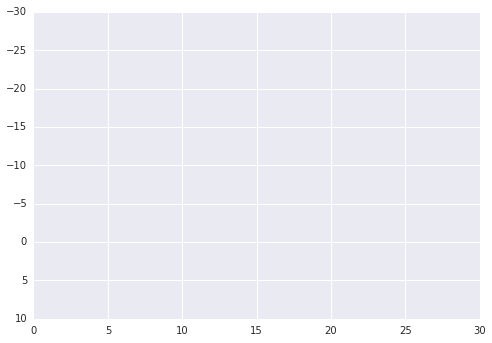

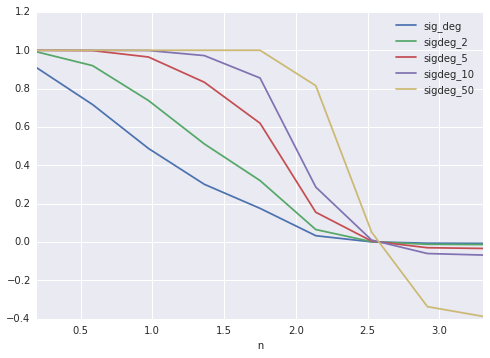

In [167]:
import glob
ss = pd.read_csv(os.path.join(montecarlofolder, "n_discrete_bootstrapped_steadystate.csv"), header=[0,1], index_col=0)
#groups = ss.groupby(ss['n']['0'])

bins = np.linspace(float(ss.n.min()), float(ss.n.max()), 10)
groups = ss.groupby(pd.cut(ss['n']['0'], bins))

#display.display(groups.mean()['dr'].transpose())
slope_array = []
for name, g in groups:
    name = name[1:-1]
    l, h = name.split(", ")
    l = float(l)
    h = float(h)
    n = np.average([l, h])
    #n = float(name)
    display.display(name)
    dyr = g['dr']
    dyr.columns.name = 'layer'
    dyr = dyr.stack('layer')
    dyr = dyr.reset_index('layer')
    dyr = dyr.reset_index()
    dyr.columns = ["sample", "layer", "dr"]
    dyr['layer'] = [float(x) for x in dyr['layer']]
    dyr['sample'] = [float(x) for x in dyr['sample']]
    dyr['dr_log'] = np.log10(dyr['dr'])
    dyr = dyr.loc[dyr['dr_log'] != -float("inf")]
    dyr = dyr.loc[dyr['dr_log'] != float("inf")]
    dyr = dyr.loc[dyr['layer'] > 15]
    sample_groups = dyr.groupby('sample')
    for nm, g in sample_groups:
        display.clear_output(wait=True)
        plt.ylim(10, -30)
        plt.xlim(0,30)
        #sns.lmplot(x='layer', y="dr_log", data=g)
        #display.display(plt.gcf())
        display.display("Sample Number %s out of %s" % (str(nm), str(dyr['sample'].max())))
        display.display("Group: %s" % name)
        mod = smf.quantreg('dr_log ~ layer', g)
        res = mod.fit(q=.5)
        intercept, slope = res.params
        slope_array.append([n, slope, 1-10**-slope])
slope_array = pd.DataFrame(slope_array)
slope_array.columns = ["n", "slope", "sig_deg"]
for deltam in [2, 5, 10, 50]:
    colname = 'sigdeg_%d' % deltam
    slope_array[colname] = 1 - 10**(-deltam * slope_array.slope)
sigdegfolder = os.path.join(finalfolder, "signaldegradation")
slope_array.to_csv(os.path.join(sigdegfolder, "signaldegradation_data.csv"))
df = slope_array.drop('slope', axis=1)
grouped = df.groupby('n')
m = grouped.median()
m.plot()

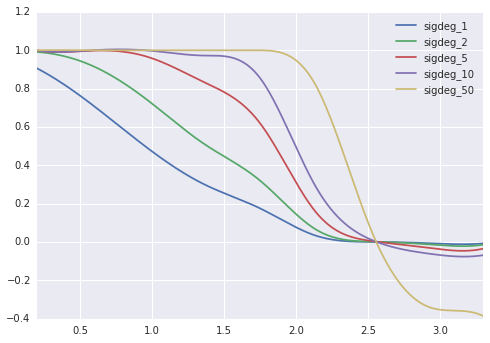

In [205]:
from scipy.interpolate import spline
from scipy.interpolate import interp1d
sa = pd.DataFrame()
slope_array = slope_array_store.copy()
sa['n'] = slope_array['n']
for deltam in [1, 2, 5, 10, 50]:
    colname = 'sigdeg_%d' % deltam
    sa[colname] = 1 - 10**(-deltam * slope_array.slope)
sigdegfolder = os.path.join(finalfolder, "signaldegradation")
sa.to_csv(os.path.join(sigdegfolder, "signaldegradation_data.csv"))
grouped = sa.groupby('n')
m = grouped.median()

p = []
for c in m.columns:
    x = np.linspace(0.2, 3.3, 1000)
    y = interp1d(m.index, m[c], kind="cubic")(x)
    df = pd.DataFrame(y, index=x, columns=[c])
    p.append(df)
sigdegplot = pd.concat(p, axis=1)
sigdegplot.plot()
plt.savefig(os.path.join(finalfolder, "signaldegradation", "signaldegradation_plot.png"), format="png")
plt.savefig(os.path.join(finalfolder, "signaldegradation", "signaldegradation_plot.pdf"), format="pdf")
sigdegplot.to_csv(os.path.join(finalfolder, "signaldegradation", "signaldegradation_data.csv"))
sa.to_csv(os.path.join(finalfolder, "signaldegradation", "signaldegradation_data_raw.csv"))

<h3> Boot Strapped Metric Calculation </h3>

** Need to do weighted averages of slopes **

ValueError: Data has no positive values, and therefore can not be log-scaled.

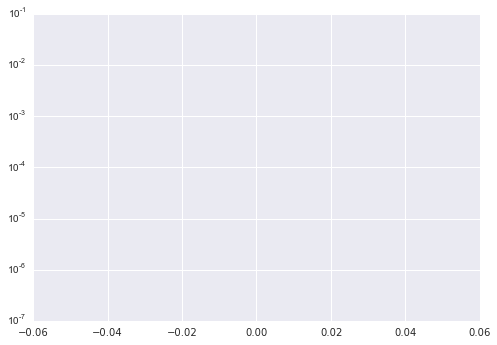

In [36]:
import seaborn as sns
import statsmodels.api as sm

import statsmodels.formula.api as smf
ss = pd.read_csv(os.path.join(montecarlofolder, "n_discrete_bootstrapped_steadystate.csv"), header=[0,1], index_col=0)
bins = np.linspace(float(ss.n.min()), float(ss.n.max()), 50)
groups = ss.groupby(pd.cut(ss['n']['0'], bins))
groups.mean()['dr'].transpose().plot(logy=True)
plt.show()
slope_array = []
message = ""
for name, g in groups:
    #display.display(name)
    name = name[1:-1]
    l, h = name.split(", ")
    l = float(l)
    h = float(h)
    n = np.average([l, h])
    #display.display(n)
    if 1==1: #name == "(0.1, 0.478]":
        h = g['dr']
        h.columns.name = "layer"
        h = h.stack('layer')
        h = h.reset_index('layer')
        h = h.reset_index()
        h.columns = ["sample", "layer", "dr"]
        h['layer'] = [float(x) for x in h['layer']]
        h['sample'] = [float(x) for x in h['sample']]
        h['dr_log'] = np.log10(h['dr'])
        h = h.loc[h['dr_log'] != -float("inf")]
        h = h.loc[h['dr_log'] != float("inf")]
        h = h.loc[h['layer'] > 15]
        sample_groups = h.groupby('sample')
        
        # Start of batched ols
        '''res = smf.ols('dr_log ~ layer', h).fit()
        intercept, slope = res.params
        slope_array.append([n, slope, 1-10**(-1*slope)])
        display.clear_output(wait=True)
        display.display(n)'''
        for nm, g in sample_groups:
            if nm > 3000:
                #continue
                pass
            display.clear_output(wait=True)
            plt.ylim(10, -30)
            plt.xlim(0,30)
            #sns.lmplot(x='layer', y="dr_log", data=g)
            #display.display(plt.gcf())
            display.display("Sample Number %s out of %s" % (str(nm), str(h['sample'].max())))
            display.display("Group: %s" % name)
            mod = smf.quantreg('dr_log ~ layer', g)
            res = mod.fit(q=.5)
            intercept, slope = res.params
            slope_array.append([n, slope, 1-10**-slope])
slope_array = pd.DataFrame(slope_array)
slope_array.columns = ["n", "slope", "sig_deg"]
slope_array.to_csv(os.path.join(montecarlofolder, "sigdeg_data.csv"))
sns.boxplot(x="n", y="sig_deg", data=slope_array)
#metric_df = pd.DataFrame(slope_array)
#metric_df.columns = ["n", "sig deg"]
#display.display(metric_df)
#bins = np.linspace(ss.n.min(), ss.n.max(), 10)
#print bins
#plt.yscale('log')
#ss['dr'].apply(np.average).plot()
slope_array_copy = slope_array.copy()
sigdegfolder = os.path.join(finalfolder, "signaldegradation")
slope_array.to_csv(os.path.join(sigdegfolder, "signaldegradation_data.csv"))

<h1> Final Kinetics Layers vs Time to half maximal plot </h1>

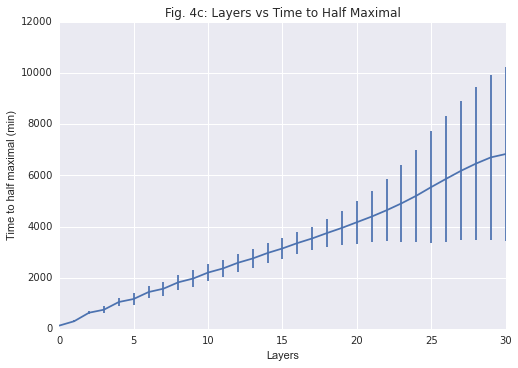

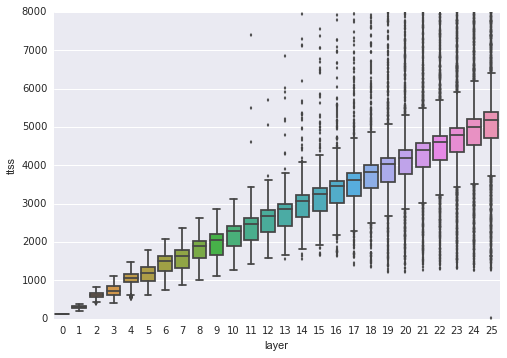

In [23]:
import pandas as pd
import numpy as np
import pylab as plt
import os
import seaborn as sns

read_p = pd.read_csv(os.path.join(montecarlofolder, "bootstrapped_kinetics.csv"), header=[0,1], index_col=0)
ttss = read_p['ttss']
ttss = ttss.transpose()
ttss = ttss.set_index(np.arange(31)[::-1])
ttss = ttss.apply(lambda x: x * 25.)
ttss_mean = ttss.apply(np.mean, axis=1)
ttss_sd = ttss.apply(np.std, axis=1)
#plt.plot(ttss_mean.index, ttss_mean)
plt.figure()
plt.title("Fig. 4c: Layers vs Time to Half Maximal")
plt.xlabel("Layers")
plt.ylabel("Time to half maximal (min)")
plt.errorbar(ttss_mean.index, ttss_mean, yerr=ttss_sd)

#Prepare for dataframes for saving
ttss_df = pd.DataFrame(ttss_mean)
ttss_df['layers'] = np.arange(31)[::-1]
ttss_df.columns = ['time to half max (min)', 'layers']
ttss_df['sd'] = ttss_sd
ttss_df.to_csv(datafolder + "/TimeToHalfMax.csv")
plt.show()
ttss.columns.name = "samples"
ttss = ttss.stack("samples")
ttss = ttss.reset_index("samples")
ttss = ttss.reindex()
ttss = ttss.reset_index()
ttss.columns = ["layer", "sample", "ttss"]
ttss.sort(columns=["layer"], inplace=True)
ttss = ttss[ttss['layer'] <= 25]
plt.ylim((0,8000))
sns.boxplot(x="layer", y="ttss", data=ttss, fliersize=3.0)
tthmfolder = os.path.join(finalfolder, "time-to-half-maximal")
plt.savefig(os.path.join(tthmfolder, "time-to-half-maximal_boxplot.png"), format='png')
plt.savefig(os.path.join(tthmfolder, "time-to-half-maximal_boxplot.pdf"), format='pdf')
ttss.to_csv(os.path.join(tthmfolder, "time-to-half-maximal_row.csv"))
read_p.to_csv(os.path.join(tthmfolder, "time-to-half-maximal_raw.csv"))
grouped = ttss.groupby('layer')
summary = grouped.describe()
summary = summary.unstack('layer')
summary.to_csv(os.path.join(tthmfolder, "time-to-half-maximal_summary.csv"))

In [48]:
steadystate_filename

'/Users/Justin/Documents/Programming/CRISPRCascadeAnalysis/hyakfitting_results/bestfits_steadystate_indexed.csv'

In [234]:
import statsmodels.api as sm

import statsmodels.formula.api as smf

mod = smf.quantreg('ttss ~ layer', ttss)
res = mod.fit(q=.5)
display.display(res.summary())

mod = smf.ols('ttss ~ layer', ttss)
res = mod.fit(q=.5)
display.display(res.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                   ttss   Pseudo R-squared:               0.7632
Model:                       QuantReg   Bandwidth:                       19.34
Method:                 Least Squares   Sparsity:                        881.6
Date:                Sat, 10 Oct 2015   No. Observations:               564200
Time:                        08:27:50   Df Residuals:                   564198
                                        Df Model:                            1
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    145.5882      1.141    127.645      0.000       143.353   147.824
layer        204.4118      0.078   2612.538      0.000       204.258   204.565
==============================================================================
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   ttss   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                 2.205e+06
Date:                Sat, 10 Oct 2015   Prob (F-statistic):               0.00
Time:                        08:27:50   Log-Likelihood:            -4.5586e+06
No. Observations:              564200   AIC:                         9.117e+06
Df Residuals:                  564198   BIC:                         9.117e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    126.5221      2.021     62.592      0.000       122.560   130.484
layer        205.9060      0.139   1484.904      0.000       205.634   206.178
==============================================================================
Omnibus:                   849633.935   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        390413555.909
Skew:                           9.449   Prob(JB):                         0.00
Kurtosis:                     130.477   Cond. No.                         28.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<h1> Metric: Log Slope </h1>

np.log10(dr_plot[25]/dr_plot[15])/10.0

$$ dynamic range = \rho  = 20.0log_{10}(\frac{max}{min}) $$
$$ η = log_{10}(\frac{\rho_{i+1}}{\rho_i}) $$

In [ ]:
plt.plot(n_array, logslope)
plt.plot(n_array, logslope*5)
plt.plot(n_array, logslope*10)
plt.legend()
plt.title("Ratio Change in Dynamic Range 10^(layer * logslope) vs n")
plt.show()

<h1> Metric: Signal Degradation (Dynamic Range Loss) </h1>


$$ dynamic range = \rho_{m}  = log_{10}(\frac{max(r_{m}(u))}{min(r_{m}(u))}) $$


$$ log_{10}(\rho_{m+x}) = η x + log_{10}(\rho_m) $$


$$ \frac{log_{10}(\rho_{m+Δm}) - log_{10}(\rho_{m})}{Δm} = η $$


$$ ηΔm = log_{10}(\frac{\rho_{m+Δm}}{\rho_m}) $$


$$ δ_{n}(Δm) = 1 - \frac{\rho_{i+j}}{\rho_i} = 1 - 10^{ηΔm}$$


$$ δ_{n}(Δm): signal degradation between Δm layers $$


$$ m: mth layer $$
$\phi$ = 1.0: 100% dynamic range loss at x layers

$\phi$ = 0.5: 50% dynamic range loss at x layers

In [17]:
n_array = []    
metric = []
logslope = []
dr_plots = []
for n in np.linspace(0.1, 3.0, 100):
    p = list(globalparams['mean'])
    p[-1] = n
    dr_plot = dynamic_range_plot(50, *p)
    dr_plots.append(dr_plot)
    logslope.append(np.log10(dr_plot[25]/dr_plot[15])/10.0)
    n_array.append(n)
metric = np.array(metric)
n_array = np.array(n_array)
logslope = np.array(logslope)
plt.yscale('log')
#plt.legend()
plt.show()

display.display(globalparams)
metriccsv = pd.DataFrame([n_array, 1.0*np.array(metric)]).transpose()
metriccsv.columns = ["n", "Metric"]
#metriccsv
plt.plot(n_array, logslope)

NameError: name 'globalparams' is not defined

In [43]:
plt.plot(n_array, 1-10**(1*logslope), label="1 layer")
plt.plot(n_array, 1-10**(2*logslope), label="2 layers")
plt.plot(n_array, 1-10**(5*logslope), label="5 layers")
plt.plot(n_array, 1-10**(10*logslope), label="10 layers")
plt.plot(n_array, 1-10**(100*logslope), label="100 layers")
plt.plot(n_array, 1-10**(100000*logslope), label="1000 layers")
plt.scatter(globalparams['mean']['n'], 0.2)
plt.ylim(-0.2, 1.1)
plt.legend()
plt.title("Ratio Change in Dynamic Range 10^(layer * logslope) vs n")
plt.show()

NameError: name 'n_array' is not defined

<h1> Hill co-efficient metric plot </h1>

In [ ]:
import pandas as pd
import numpy as np
import pylab as plt
read_p = p
dr_diff = read_p['dr_diff']#.iloc[:,25:]
dr_diff = pd.DataFrame(dr_diff.apply(np.mean, axis=1))
dr = read_p['dr']
plt.figure()
#plt.yscale('log')
n0 = read_p['dr_diff'].iloc[:,0]
n11 = read_p['dr_diff'].iloc[:,11]

#plt.scatter(np.array(read_p['n']), n0/n10)
plt.title("Range Plot")
plt.scatter(np.array(read_p['n']), dr_diff)
plt.show()


plt.yscale('linear')
plt.xlim(0.5, 2.5)
plt.ylim(-1, 4)


# Dynamic Range
ss = read_p['ss']
ss_0 = read_p['ss_0']
dynamic_range = np.abs(np.log10(ss) - np.log10(ss_0))
dynamic_range_mean = dynamic_range.iloc[:,4:5].apply(np.mean, axis=1)
dynamic_range_mean2 = dynamic_range.iloc[:,10:11].apply(np.mean, axis=1)
dynamic_range_ratio = dynamic_range_mean2/dynamic_range_mean


l = dynamic_range.transpose()
lsd = dynamic_range.transpose()
lsd = l.apply(np.std, axis=1)
l = l.apply(np.mean, axis=1)
l.plot()
plt.show()

var = dynamic_range_ratio
plt.scatter(np.array(read_p['n']), var)
plt.title("Test Metric")
plt.show()

plt.scatter(np.array(read_p['n']), dynamic_range_mean)
plt.title("Dynamic Range Scatter")
plt.yscale('linear')
plt.xlabel('n')
plt.ylabel('dyanmic range (log(ss/ss_0))')
plt.xlim(0.5, 2.5)
plt.ylim(-1, 4)
plt.savefig("/Users/Justin/Desktop/ModelingAnalysis_9-14-15/DynamicRangeScatterPlot.png")
plt.show()
df = pd.DataFrame(dynamic_range_mean)
df['n'] = np.array(read_p['n'])

#Bin data and calculate standard deviation
#df = pd.DataFrame(dr.iloc[:,4:5].apply(np.mean, axis=1))
#df['n'] = np.array(read_p['n'])
bins = np.arange(df.n.min(), df.n.max(), 0.05)
groups = df.groupby(pd.cut(df.n, bins))
g = groups.mean()
gsd = groups.std()
plt.title("Dynamic Range")
plt.yscale('linear')
plt.xlabel('n')
plt.ylabel('dyanmic range (log(ss/ss_0))')
plt.xlim(0.5, 2.5)
plt.ylim(-1, 4)
plt.errorbar(g['n'], g[0], yerr=gsd[0])
plt.savefig(analysisFolder + "/DynamicRangePlot.png")
dynamicrange_dataframe = pd.DataFrame(
                                        {'n': np.array(g['n']), 
                                       'dynamic range |log(ss) - log(ss_0)|': np.array(g[0]),
                                       'sd': np.array(gsd[0])
                                        })
dynamicrange_dataframe.to_csv(analysisFolder + "dynamicrangeplot.csv")

read_p.to_csv(analysisFolder + "distributionForDynamicRangePlot.csv")

<h1> Dynamic Range Plot </h1>

In [ ]:
range(20)[0] - range(20)[1]

<h1> Import Dose Response </h1>

strain
6059    0.941733
6325    0.792967
6326    0.644373
6327    0.647548
dtype: float64

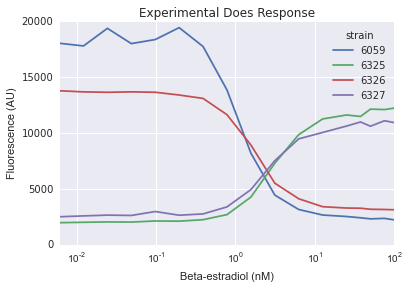

In [74]:
import pandas as pd
import pylab as plt
name = os.path.join(datafolder, "ExperimentalData", "DoseResponse.csv")
exp_dose = pd.read_csv(name)
AU = exp_dose['FL1.Amean']
treatment = exp_dose['treatment']
exp_dose = pd.pivot_table(exp_dose, index='treatment', columns=["strain"], values="FL1.Amean")
ax = exp_dose.plot(logx=True, logy=False)
ax.set_xlabel("Beta-estradiol (nM)")
ax.set_ylabel("Fluorescence (AU)")
ax.set_title("Experimental Does Response")
ax
exp_dose

mx = exp_dose.apply(np.max)
mn = exp_dose.apply(np.min)
np.log10(mx/mn)

<h1> Importing Kinetics Data </h1>

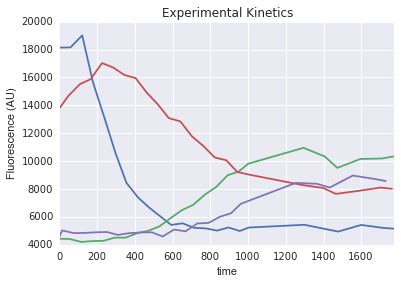

In [75]:
layers = []
for i in range(1,5):
    name = os.path.join(datafolder, "ExperimentalData", "KineticsLayer%d.csv" % i)
    layers.append(pd.read_csv(name, header=None))
layers1, layers2, layers3, layers4 = layers
header = ['time', 'au']
layers1.columns = header
layers2.columns = header
layers3.columns = header
layers4.columns = header
layers1['layer'] = 1
layers2['layer'] = 2
layers3['layer'] = 3
layers4['layer'] = 4
layers = pd.concat([layers1, layers2, layers3, layers4])
layers_table = pd.pivot_table(layers, values='au', columns=['layer'], index='time')
layers.sort(columns=['time', 'layer'])
layers['au'] = layers['au'] + 2000.
layers.stack()
layers
exp_kinetics = pd.pivot_table(layers, values='au', index=['layer', 'time'])
exp_kinetics
plt.figure()
plt.xlabel("Time (min)")
plt.ylabel("Fluorescence (AU)")
plt.title("Experimental Kinetics")
exp_kinetics[1].plot()
exp_kinetics[2].plot()
exp_kinetics[3].plot()
exp_kinetics[4].plot()
plt.show()

<h1> Plot Best Fits </h1>

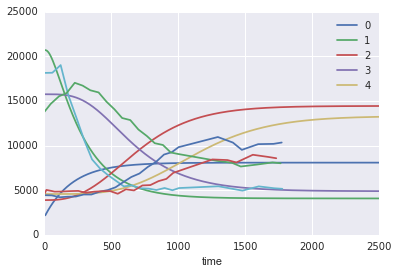

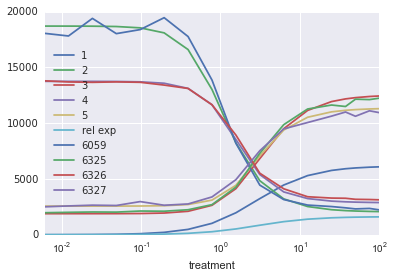

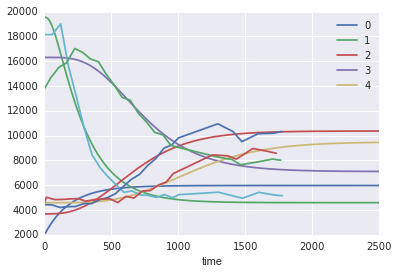

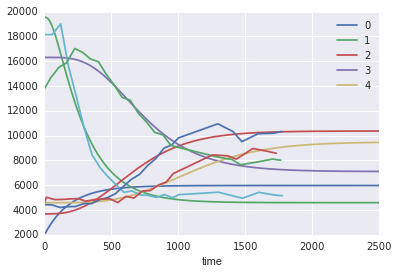

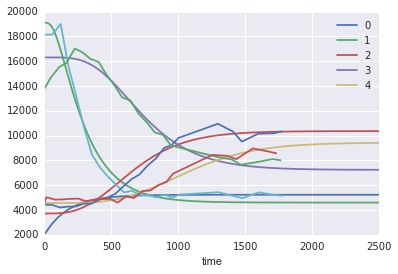

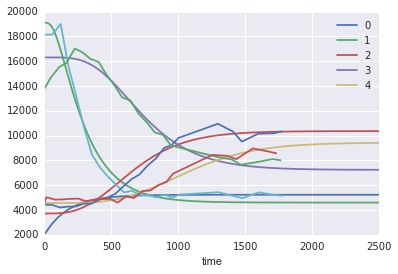

In [104]:
t_final = 100.
#modelparams, globalparams = getParamUncertainties(combined_filename)
#modelparams, globalparams = getParamUncertainties(steadystate_filename)
#modelparams, globalparams = getParamUncertainties(kinetics_filename)

def plotBest(infile, kout = None, ssout=None):
    params = pd.read_csv(infile, header=[0,1], index_col=0)
    params = params.loc['50%']
    a = list(params['a'])
    k = list(params['k'])
    u = float(params['u'])
    b = params['b']
    n = float(params['n'])
    b1 = b2 = b
    if len(b) == 2:
        b1, b2 = b
    else:
        b1 = float(b)
        b2 = b1
    refinedmodel = ssModel(0.006*2**np.linspace(0,20,1000), a, k, b2, u, n) * 1600.0
    m = ssModel(exp_dose.index, a, k, b2, u, n) * 1600.0
    dose_combined = m.join(exp_dose)
    k = kineticsModel(a, k, b1, u, n) * 1600.0 + 2000.0
    k = k.set_index(k.index * 25.0)
    k.plot()
    exp_kinetics[1].plot()
    exp_kinetics[2].plot()
    exp_kinetics[3].plot()
    exp_kinetics[4].plot()
    if not ssout == None:
        refinedmodel.to_csv(ssout)
        dose_combined.plot(logx=True)
        plotfigpath = os.path.join(os.path.dirname(ssout), os.path.basename(ssout).split(".")[0])
        plt.savefig(plotfigpath + ".png", format="png")
        plt.savefig(plotfigpath + ".pdf", format="pdf")
    if not kout == None:
        k.to_csv(kout)
        k.plot()
        exp_kinetics[1].plot()
        exp_kinetics[2].plot()
        exp_kinetics[3].plot()
        exp_kinetics[4].plot()
        plotfigpath = os.path.join(os.path.dirname(kout), os.path.basename(kout).split(".")[0])
        plt.savefig(plotfigpath + ".png", format="png")
        plt.savefig(plotfigpath + ".pdf", format="pdf")
ss_in = os.path.join(finalfolder, 'parameters', 'ss_fit_summary.csv')
ss_out = os.path.join(finalfolder, 'parameters', 'ss_fit.csv')

k_in = os.path.join(finalfolder, 'parameters', 'kinetics_fit_summary.csv')
k_out = os.path.join(finalfolder, 'parameters', 'kinetics_fit.csv')

knew_in = os.path.join(finalfolder, 'parameters', 'kineticsnew_fit_summary.csv')
knew_out = os.path.join(finalfolder, 'parameters', 'kineticsnew_fit.csv')

plotBest(ss_in, ssout=ss_out)
plotBest(k_in, kout=k_out)
plotBest(knew_in, kout=knew_out)

In [ ]:
t_final = 100.
kinetics_trajectories = []
ss_trajectories = []
p = pd.read_csv("/Users/Justin/Documents/Programming/CRISPRCascadeAnalysis/Data/hyakfitting_results/bestfits_combined_indexed.csv", header=[0,1], index_col=0)
for index in range(len(p)):
    index = 1
    a = list(p.iloc[index]['a'])
    k = list(p.iloc[index]['k'])
    u = p.iloc[index]['u'][0]
    b1, b2 = p.iloc[index]['b']
    n = p.iloc[index]['n'][0]

    m = ssModel(exp_dose.index, a, k, b2, u, n) * 1600.0
    k = kineticsModel(a, k, b1, u, n) * 1600.0
    k = k.set_index(k.index * 25.0)
    kinetics_trajectories.append(k)
    ss_trajectories.append(m)

In [42]:
import seaborn as sns
trajectories = kinetics_trajectories
doseresponses = ss_trajectories
for i, t in enumerate(trajectories):
    t['unit'] = i
    t['time'] = t.index
traj_pd = pd.concat(trajectories)
trajmelt = pd.melt(traj_pd, id_vars=["time", "unit"], var_name="layers")
trajmelt['layers'] = max(trajmelt['layers']) - trajmelt['layers']
trajmelt.to_csv(analysisfolder + "Data/MonteCarlo/trajectories.csv")

for i, d in enumerate(doseresponses):
    d['unit'] = i
    d['dose'] = np.log10(d.index)
dose_pd = pd.concat(doseresponses)
dosemelt = pd.melt(dose_pd, id_vars=["dose", "unit", 'rel exp'], var_name="layers")
dosemelt.to_csv(analysisfolder + "Data/MonteCarlo/doseresponses.csv")

trajmelt = trajmelt[trajmelt.layers < 10]
sns.tsplot(data=trajmelt, time="time", unit="unit", condition="layers", value="value", err_style=["boot_traces"], ci=[95])
plt.show()

dosemelt = dosemelt[dosemelt.layers < 10]
sns.tsplot(data=dosemelt, time="dose", unit="unit", condition="layers", value="value", err_style=["ci_band"], ci=[95])
plt.show()

NameError: name 'kinetics_trajectories' is not defined

<h1> Fancy plotting of parameters vs metrics </h1>

In [ ]:
sns.set_style("whitegrid")
layer1 = test.stack(level=0).unstack()[0]
layers = []
for l in range(1,29):
    layer = test.stack(level=0).unstack()[l]
    layer['b'] = layer1['b']
    layer['n'] = layer1['n']
    layer['u'] = layer1['u']
    layer['layer'] = l
    layers.append(layer)
layers = pd.concat(layers)
#m = pd.melt(layer, id_vars=['a', 'b', 'k', 'n', 'u'], var_name="metric", value_name="metric_value")
#m = pd.melt(m, id_vars=["metric", "metric_value"], var_name="params", value_name="param_value")


#grid = sns.FacetGrid(m, row="params", col="metric", hue="params")

#grid.map(plt.scatter, "param_value", "metric_value")
#grid.fig.tight_layout(w_pad=1)
#sns.pairplot(layers, hue="layer", x_vars=["a", "b", "k", "n", "u"], y_vars=["dr", "ttss"], kind="reg")
plt.show()
layers['metric'] = layers['dr']/layers['layer']
#sns.jointplot("n", "metric", data=layers)
plt.show()
#sns.tsplot(data=layers, time='n', value="metric", unit="layer")
bins = np.arange(layers.n.min(), layers.n.max(), 0.05)
groups = layers.groupby(pd.cut(layers.n, bins))
g = groups.mean()
gsd = groups.std()
print g
dynamicrange_dataframe = pd.DataFrame(
                                        {'n': np.array(g['n']), 
                                       'metric': np.array(g['metric']),
                                       'sd': np.array(gsd['metric'])
                                        })
plt.errorbar(dynamicrange_dataframe['n'], dynamicrange_dataframe['metric'], yerr=dynamicrange_dataframe['sd'])

<h1> Fancy plotting of models with Seaborn </h1>

In [ ]:
import seaborn as sns
trajectories = largeuniform_traj
doseresponses = largeuniform_modelss
for i, t in enumerate(trajectories):
    t['unit'] = i
    t['time'] = t.index
traj_pd = pd.concat(trajectories)
trajmelt = pd.melt(traj_pd, id_vars=["time", "unit"], var_name="layers")
trajmelt['layers'] = max(trajmelt['layers']) - trajmelt['layers']
trajmelt.to_csv(analysisfolder + "Data/MonteCarlo/trajectories.csv")

for i, d in enumerate(doseresponses):
    d['unit'] = i
    d['dose'] = np.log10(d.index)
dose_pd = pd.concat(doseresponses)
dosemelt = pd.melt(dose_pd, id_vars=["dose", "unit", 'rel exp'], var_name="layers")
dosemelt.to_csv(analysisfolder + "Data/MonteCarlo/doseresponses.csv")

trajmelt = trajmelt[trajmelt.layers < 10]
sns.tsplot(data=trajmelt, time="time", unit="unit", condition="layers", value="value", err_style=["ci_band"], ci=[95])
plt.show()

dosemelt = dosemelt[dosemelt.layers < 10]
sns.tsplot(data=dosemelt, time="dose", unit="unit", condition="layers", value="value", err_style=["ci_band"], ci=[95])
plt.show()

<h3> Boot Strap </h3>

In [15]:
t_final = 100.
fits = pd.read_csv(steadystate_filename, index_col=0, header=[0,1])
trajectories = []
doseresponses = []
for index, row in fits.iterrows():
    a = row['a']
    k = row['k']
    b1, b2 = row['b']
    u = row['u']
    n = float(row['n'])
    a = list(a)
    k = list(k)
    u = u[0]
    traj = ssModel(exp_dose.index, a, k, b2, u, n)
    display.clear_output(wait=True)
    plt.xscale('log')
    traj.plot()
    #display.display(row)
    display.display(plt.gcf())

KeyboardInterrupt: 

KeyboardInterrupt: 

In [163]:
import glob
scripts = os.path.join(datafolder, "151007_hyakfittingscripts", "output_fittingscript_kinetics_100715")
files = glob.glob(os.path.join(scripts, "*.csv"))
best = []
df = None
for f in files:
    df = pd.read_csv(f, header=[0,1], index_col=0)
    lastrow = df.iloc[-1]
    best.append(lastrow)
best = pd.DataFrame(best)
best = best.reset_index()
best.to_csv(os.path.join(hyakfolder, "bestfits_kinetics_new_indexed.csv"))